## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [11]:
import itertools

In [5]:
train, test = keras.datasets.cifar10.load_data()

In [6]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [7]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [13]:
from keras.regularizers import l1, l2, l1_l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4, regular_type=0):
    input_layer = keras.layers.Input(input_shape)
    if regular_type == 0:
        regular = l1(l2_ratio)
        type_name = "l1"
    if regular_type == 1:
        regular = l2(l2_ratio)
        type_name = "l2"
    if regular_type == 2:
        regular = l1_l2(l2_ratio)
        type_name = "l1_l2"
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name=type_name+"_hidden_layer"+str(i+1), 
                                   kernel_regularizer=regular)(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name=type_name+"_hidden_layer"+str(i+1),
                                   kernel_regularizer=regular)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [15]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 20
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8]
regulizer_type = [0, 1]

In [17]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_choose, regulizer_ratio in itertools.product(regulizer_type, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio, regular_type=regulizer_choose)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    if regulizer_choose == 0:
        regulizer_name = "l1"
    if regulizer_choose == 1:
        regulizer_name = "l2"
    if regulizer_choose == 2:
        regulizer_name = "l1_l2"
    exp_name_tag = regulizer_name + "_exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
l1_hidden_layer1 (Dense)     (None, 512)               1573376   
_________________________________________________________________
l1_hidden_layer2 (Dense)     (None, 256)               131328    
_________________________________________________________________
l1_hidden_layer3 (Dense)     (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 15s 294us/step - loss: 2.0448 - acc: 0.2748 - val_loss: 1.8689 - val_acc: 0.3429
Epoch 2/20
50000/50000 [==============================] - 14s 281us/step - loss: 1.8124 - acc: 0.3644 - val_loss: 1.7591 - val_acc: 0.3820
Epoch 3/20
50000/50000 [==============================] - 14s 282us/step - loss: 1.7297 - acc: 0.3952 - val_loss: 1.6989 - val_acc: 0.4060
Epoch 4/20
50000/50000 [==============================] - 14s 282us/step - loss: 1.6726 - acc: 0.4137 - val_loss: 1.6550 - val_acc: 0.4170
Epoch 5/20
50000/50000 [==============================] - 14s 282us/step - loss: 1.6283 - acc: 0.4292 - val_loss: 1.6152 - val_acc: 0.4289
Epoch 6/20
50000/50000 [==============================] - 14s 282us/step - loss: 1.5896 - acc: 0.4428 - val_loss: 1.5798 - val_acc: 0.4488
Epoch 7/20
50000/50000 [==============================] - 14s 289us/step - loss: 1.5557 - acc: 0.4563 - val_loss: 1.

Epoch 4/20
50000/50000 [==============================] - 14s 287us/step - loss: 1.8011 - acc: 0.4170 - val_loss: 1.7801 - val_acc: 0.4213
Epoch 5/20
50000/50000 [==============================] - 14s 285us/step - loss: 1.7541 - acc: 0.4339 - val_loss: 1.7524 - val_acc: 0.4291
Epoch 6/20
50000/50000 [==============================] - 14s 285us/step - loss: 1.7144 - acc: 0.4474 - val_loss: 1.7159 - val_acc: 0.4468
Epoch 7/20
50000/50000 [==============================] - 14s 285us/step - loss: 1.6792 - acc: 0.4598 - val_loss: 1.6928 - val_acc: 0.4554
Epoch 8/20
50000/50000 [==============================] - 14s 285us/step - loss: 1.6481 - acc: 0.4716 - val_loss: 1.6659 - val_acc: 0.4642
Epoch 9/20
50000/50000 [==============================] - 14s 290us/step - loss: 1.6216 - acc: 0.4796 - val_loss: 1.6698 - val_acc: 0.4592
Epoch 10/20
50000/50000 [==============================] - 14s 287us/step - loss: 1.5953 - acc: 0.4902 - val_loss: 1.6275 - val_acc: 0.4747
Epoch 11/20
50000/50000 [=

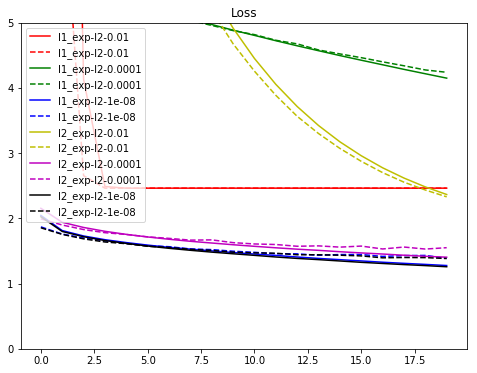

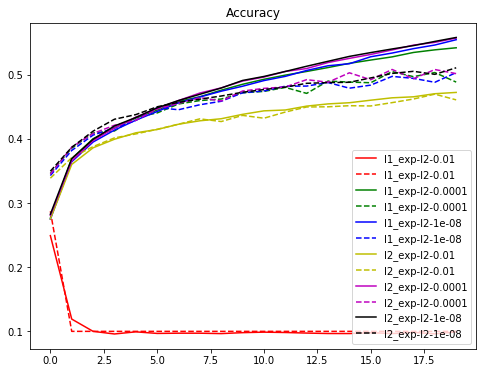

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()